In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [2]:
# get input data
deepmimo = True

function_folder = "deepmimo-gaussian_-28.444"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

             0          1          2          3          4          5  \
0    -8.203103  23.925890  13.185612 -19.436133  27.091123  16.028026   
1    10.517153  15.438129  35.112620   5.269884   1.587959  -0.350321   
2    -0.786413   9.881108  -9.950705   9.866130  23.509839  -0.649891   
3    13.983508 -10.097180   2.427623  30.564414   0.641939  -4.488938   
4    -1.287504 -19.001485  10.723595  -3.297020  27.275775  10.849665   
..         ...        ...        ...        ...        ...        ...   
135 -16.129594 -13.700230  -3.903956 -20.002251 -18.497771  -9.109704   
136  13.465683 -22.165082  -7.628285 -17.279264 -13.012792   7.100331   
137 -31.801056   6.617402   5.164138  -4.464532   0.388360   2.678873   
138   4.484712   4.176115   4.331286   4.826011  32.184870 -29.029191   
139   1.019308 -22.936863   1.015661  24.654189 -14.733008  -4.681390   

             6          7          8          9  ...       1014       1015  \
0     8.764666 -13.700273   1.633605  45.5868

In [3]:
tensors['train'][1].shape

torch.Size([140, 1024])

# Evaluate KAN

In [4]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1024]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1,1,1], [1,2,1], [1, 3, 1], [1,5,1] , [1,7,1]],   #[1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 5, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]
        'kan__grid': [3,2,1],
        'kan__k': [5,2,1],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [100]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)
# Fit RandomizedSearchCV
if not deepmimo:
    grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

    # Retrieve the best parameters and best score
    grid_search.best_params_['kan__data'] = []          # remove annoying print
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    opt_params_KAN = grid_search.best_params_


In [5]:
# evaluate KAN with optimal params
if not deepmimo:
    kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=100, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()

In [6]:
if deepmimo:
    kan_model = KANModel(width=[1024, 20, 20, 1024], grid=10, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,epochs=10, results_path=f"./results/KAN/{function_folder}")
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()
results = {}
results["test_loss"] = y_preds['test_loss']

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-01 | test_loss: 2.17e-01 | reg: 9.68e+02 | : 100%|█| 10/10 [00:47<00:00,  4.71s/


saving model version 0.1


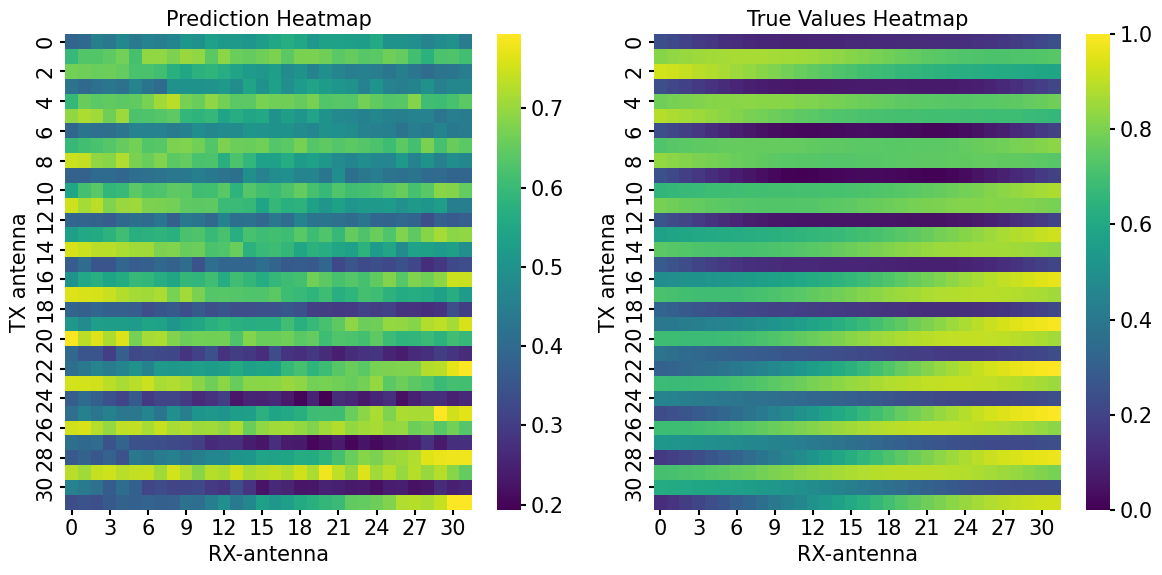

In [7]:
# plot pred and true
if deepmimo:
    pred_sample = y_preds['preds'][5]
    true_sample = tensors['test'][1][5]
    kan_model.plot_deepmimo(true_sample=true_sample, pred_sample=pred_sample,save=True)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)

plotting noisy and true


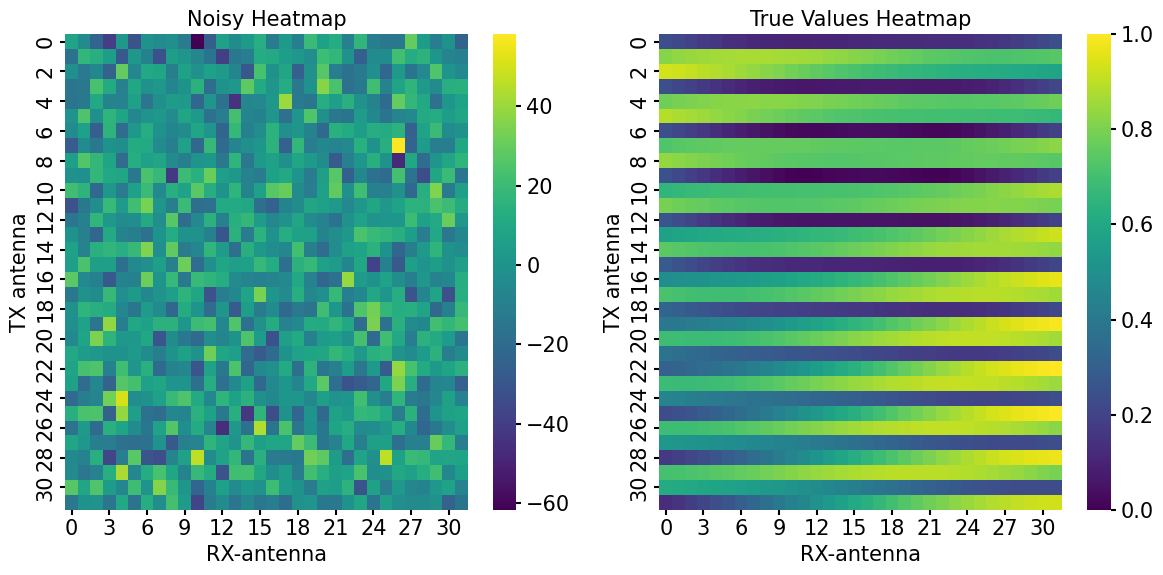

In [8]:
# plot noise and true
if deepmimo:
    print(f"plotting noisy and true")
    pred_sample = tensors['test'][0][5]
    true_sample = tensors['test'][1][5]
    kan_model.plot_deepmimo(true_sample=true_sample, pred_sample=pred_sample,save=True, noisy=True)

In [9]:
num_samples = tensors['test'][0].shape
noisy = tensors['test'][0] # [20, 1024]
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((noisy-true)**2, axis=1))
print(f"Average MSE per sample between noisy and true: {average_mse}")
results['noise-average-mse'] = average_mse

Average MSE per sample between noisy and true: 269519.3125


In [10]:
# diffrence pred and true
num_samples = tensors['test'][0].shape
preds = y_preds['preds']
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
print(f"Average MSE per sample between predicted and true for KAN: {average_mse}")
results['pred-average-mse'] = average_mse
kan_model.write_params_to_file(results)

Average MSE per sample between predicted and true for KAN: 44.821678161621094
Model parameters saved to ./results/KAN/deepmimo-gaussian_-28.444/model_params.txt


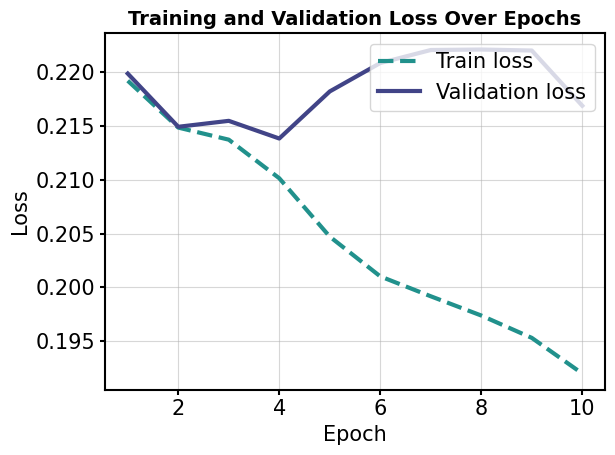

In [11]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [12]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[1000],[300,300,300],[128,128], [2000]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[1], [2], [3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001, 0.0001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=3
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  4%|▍         | 4/100 [00:00<00:09,  9.66it/s]/home/anton/Documents/kth/KAN-Kolm

[CV 4/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 93%|█████████▎| 93/100 [00:18<00:01,  4.62it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 93%|█████████▎| 93/100 [00:19<00:01,  4.15it/s]

[CV 1/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 97%|█████████▋| 97/100 [00:19<00:00,  4.44it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 99%|█████████▉| 99/100 [00:18<00:00,  4.53it/s]

[CV 5/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 99%|█████████▉| 99/100 [00:20<00:00,  4.54it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


[CV 2/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


  2%|▏         | 2/100 [00:00<00:13,  7.38it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


[CV 2/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


  9%|▉         | 9/100 [00:01<00:16,  5.52it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 97%|█████████▋| 97/100 [00:20<00:00,  3.83it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 12%|█▏        | 12/100 [00:01<00:16,  5.29it/s]

[CV 3/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


  8%|▊         | 8/100 [00:01<00:17,  5.15it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 14%|█▍        | 14/100 [00:02<00:16,  5.13it/s]

[CV 1/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 81%|████████  | 81/100 [00:16<00:03,  5.26it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 87%|████████▋ | 87/100 [00:17<00:02,  4.91it/s]

[CV 4/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 87%|████████▋ | 87/100 [00:17<00:02,  5.37it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  8%|▊         | 8/100 [00:01<00:14,  6.34it/s]]

[CV 5/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 14%|█▍        | 14/100 [00:02<00:15,  5.63it/s]

[CV 2/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  8%|▊         | 8/100 [00:01<00:15,  6.09it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 100/100 [00:20<00:00,  4.94it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.ten

[CV 1/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


  4%|▍         | 4/100 [00:00<00:11,  8.70it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 98%|█████████▊| 98/100 [00:19<00:00,  5.27it/s]

[CV 4/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


  7%|▋         | 7/100 [00:00<00:14,  6.22it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  8%|▊         | 8/100 [00:01<00:16,  5.68it/s]

[CV 1/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 88%|████████▊ | 88/100 [00:16<00:02,  4.41it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 96%|█████████▌| 96/100 [00:19<00:01,  3.81it/s]

[CV 2/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 88%|████████▊ | 88/100 [00:18<00:02,  5.15it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 93%|█████████▎| 93/100 [00:17<00:01,  5.23it/s]

[CV 3/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 13%|█▎        | 13/100 [00:01<00:15,  5.76it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 99%|█████████▉| 99/100 [00:18<00:00,  5.32it/s]

[CV 4/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]
/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 95%|█████████▌| 95/100 [00:18<00:00,  5.45it/s]

[CV 5/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 12%|█▏        | 12/100 [00:01<00:15,  5.53it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
 17%|█▋        | 17/100 [00:02<00:15,  5.50it/s]

[CV 1/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


[CV 2/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


 97%|█████████▋| 97/100 [00:14<00:00,  6.41it/s]

[CV 5/5] END mlp__data={'train': (tensor([[-8.2031e+00,  2.3926e+01,  1.3186e+01,  ...,  7.2120e+00,
          1.0738e+01,  2.9534e+00],
        [ 1.0517e+01,  1.5438e+01,  3.5113e+01,  ..., -8.9444e+00,
         -1.0614e+01, -3.0288e+00],
        [-7.8641e-01,  9.8811e+00, -9.9507e+00,  ..., -5.3928e+00,
          3.5379e+00,  2.1621e+00],
        ...,
        [-3.1801e+01,  6.6174e+00,  5.1641e+00,  ..., -8.8465e+00,
         -6.5217e+00, -6.5044e+00],
        [ 4.4847e+00,  4.1761e+00,  4.3313e+00,  ...,  1.3945e+01,
          4.8113e-01,  1.1406e+01],
        [ 1.0193e+00, -2.2937e+01,  1.0157e+00,  ..., -1.1860e-03,
          1.4796e+01,  6.7591e+00]]), tensor([[0.1466, 0.6684, 0.7186,  ..., 0.6634, 0.7523, 0.2224],
        [0.1550, 0.6464, 0.6770,  ..., 0.7244, 0.6192, 0.1518],
        [0.7567, 0.2270, 0.8568,  ..., 0.4949, 0.4100, 0.9270],
        ...,
        [0.1262, 0.6132, 0.7034,  ..., 0.5848, 0.7354, 0.2396],
        [0.1280, 0.4738, 0.6988,  ..., 0.3772, 0.7060, 0.3043],


KeyboardInterrupt: 

In [ ]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'],result_path=f"./results/MLP/{function_folder}")
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)
results = {}
results['test_loss'] = y_preds_MLP['test_loss']

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


In [ ]:
# diffrence pred and true for MLP
num_samples = tensors['test'][0].shape        
preds = y_preds_MLP['preds']
true = tensors['test'][1]

average_mse = torch.mean(torch.sum((preds-true)**2, axis=1))
print(f"Average MSE per sample between predicted and true for MLP: {average_mse}")
results['average-pred-loss'] = average_mse

Average MSE per sample between predicted and true for MLP: 32.468040466308594


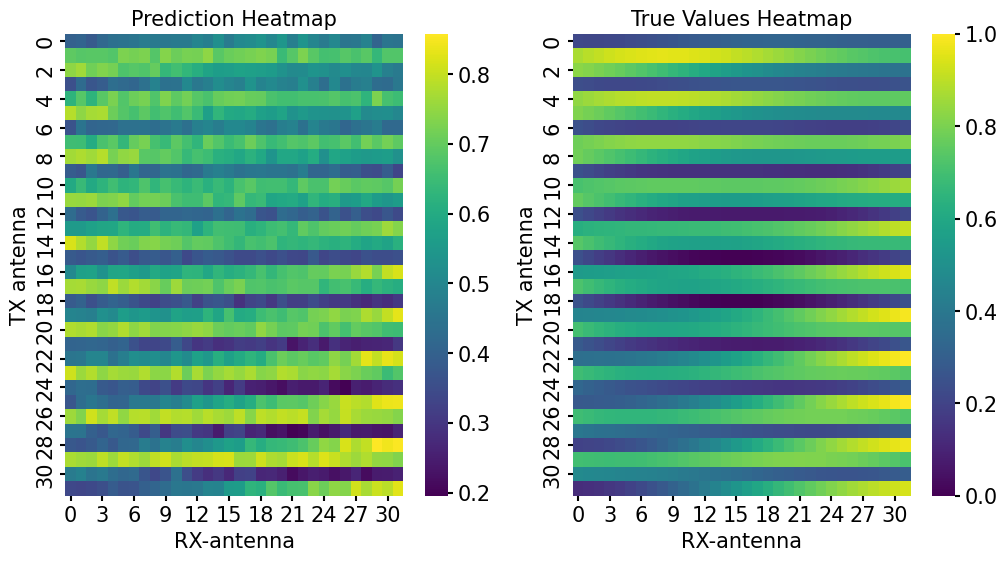

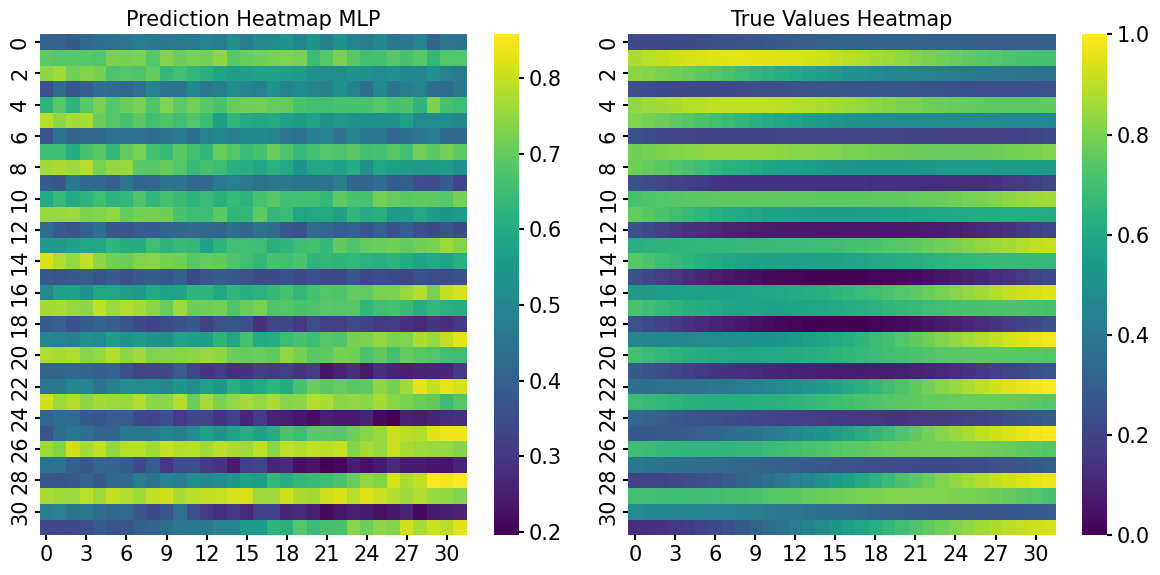

In [ ]:
# plot predictions
if deepmimo:
    pred_sample = y_preds_MLP['preds'][0]
    true_sample = tensors['test'][1][0]
    mlp_model.plot_deepmimo(pred_sample=pred_sample, true_sample=true_sample,save=True)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)

saved loss to  ./results/MLP/first_deepmimo_data/loss.png
Model parameters saved to ./results/MLP/first_deepmimo_data/model_params.txt


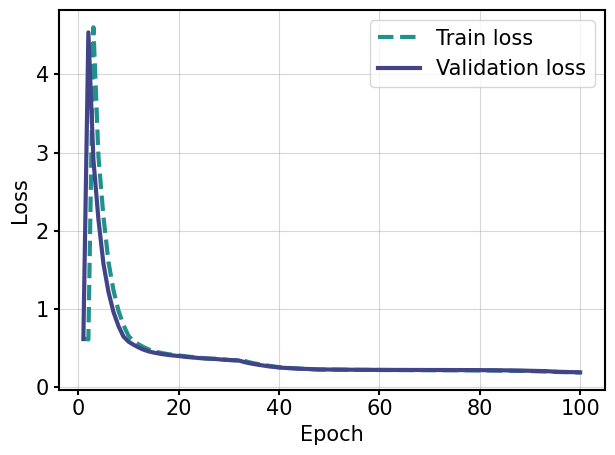

Model parameters saved to ./results/MLP/first_deepmimo_data/model_params.txt


In [ ]:

mlp_model.plot_loss(loss_data=loss_data_MLP, save=True, deepmimo=deepmimo)
# plot loss
mlp_model.write_params_to_file(results)